In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import os

In [77]:
def simulate_asset_prices(S0, mu, sigma, T, dt, seed=None):
    """
    Simulate asset prices using Geometric Brownian Motion.

    Parameters:
    - S0 (float): Initial asset price.
    - mu (float): Drift coefficient (expected return).
    - sigma (float): Volatility coefficient.
    - T (float): Total time horizon (in years).
    - dt (float): Time step size (in years).
    - seed (int, optional): Random seed for reproducibility.

    Returns:
    - pd.DataFrame: DataFrame containing time points and simulated asset prices.
    """
    if seed is not None:
        np.random.seed(seed)  # Set seed for reproducibility

    N = int(T / dt)  # Number of time steps
    time = np.linspace(0, T, N + 1)  # Time points from 0 to T inclusive
    # Generate N independent standard normal random variables
    W = np.random.normal(0, np.sqrt(dt), N)
    S = np.zeros(N + 1)
    S[0] = S0

    for i in range(1, N + 1):
        S[i] = S[i - 1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * W[i - 1])

    return pd.DataFrame({"Time": time, "Price": S})

       Time       Price
0  0.000000  100.000000
1  0.003968  100.045144
2  0.007937  100.385755
3  0.011905   99.899132
4  0.015873   99.654190


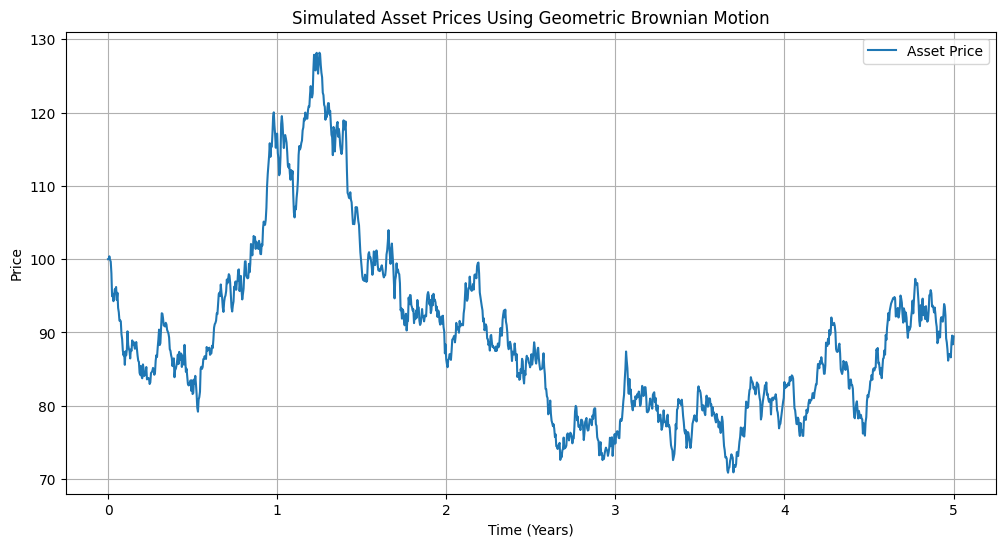

In [78]:
if __name__ == "__main__":
    # Simulation Parameters
    S0 = 100        # Initial asset price
    mu = 0.05       # Expected annual return (5%)
    sigma = 0.2     # Annual volatility (20%)
    T = 5           # Time horizon of 1 year
    dt = 1/252      # Daily time steps (assuming 252 trading days)
    seed = 45       # Random seed for reproducibility

    # Simulate Asset Prices
    asset_prices_df = simulate_asset_prices(S0, mu, sigma, T, dt, seed=seed)

    # Display First Few Rows
    print(asset_prices_df.head())

    # Plot Asset Price Trajectory
    plt.figure(figsize=(12, 6))
    plt.plot(asset_prices_df["Time"], asset_prices_df["Price"], label="Asset Price")
    plt.title("Simulated Asset Prices Using Geometric Brownian Motion")
    plt.xlabel("Time (Years)")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()

In [79]:
def black_scholes(S, K, T, r, sigma, option_type='call'):
    
    T = max(T, 1e-10)
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    try:
        if option_type == 'call':
            price = S * norm.cdf(d1) - norm.cdf(d2) * K * np.exp(- r * T)
        elif option_type == 'put':
            price = K * np.exp(- r * T) * norm.cdf(- d2) - S * norm.cdf(- d1)
        else:
            raise ValueError("option_price must be a 'call' or a 'put'")
        return price
    except Exception as e:
        print(f"Error calculating option price: {e}")
        return np.nan  # Return NaN to handle exceptions

In [80]:
asset_prices_df["Time"] = pd.date_range(start = '2023-01-01', periods = (1 / dt) * T + 1, freq = 'D')

In [81]:
strike_prices = [80, 90, 100, 110, 120]  # List of strike prices
r = 0.04        # Risk-free interest rate
sigma = 0.2     # Volatility
expiration_date = pd.to_datetime('2023-05-01')  # Option expiration date

# Calculate time to expiration
asset_prices_df['Time'] = pd.to_datetime(asset_prices_df['Time'])
# asset_prices_df['T'] = (expiration_date - asset_prices_df['Time']).dt.days / 365.0
# asset_prices_df['T'] = asset_prices_df['T'].apply(lambda x: max(x, 1/365))  # Prevent non-positive T

# Loop over each strike price and calculate option prices
for K in strike_prices:
    # Calculate call option prices
    asset_prices_df[f'Call_{K}'] = asset_prices_df.apply(
        lambda row: black_scholes(row['Price'], K, T, r, sigma, 'call'), axis=1)
    
    # Calculate put option prices
    asset_prices_df[f'Put_{K}'] = asset_prices_df.apply(
        lambda row: black_scholes(row['Price'], K, T, r, sigma, 'put'), axis=1)

# Display the DataFrame with the new columns
print(asset_prices_df.head())

        Time       Price    Call_80    Put_80    Call_90    Put_90   Call_100  \
0 2023-01-01  100.000000  37.787444  3.285904  31.882222  5.567990  26.703538   
1 2023-01-02  100.045144  37.827128  3.280444  31.919140  5.559764  26.737350   
2 2023-01-03  100.385755  38.126839  3.239544  32.198070  5.498083  26.992932   
3 2023-01-04   99.899132  37.698809  3.298137  31.799779  5.586414  26.628041   
4 2023-01-05   99.654190  37.483763  3.328033  31.599829  5.631406  26.445011   

    Put_100   Call_110    Put_110   Call_120    Put_120  
0  8.576613  22.234651  12.295034  18.428278  16.675968  
1  8.565282  22.265196  12.280434  18.455543  16.658090  
2  8.480252  22.496178  12.170806  18.661828  16.523763  
3  8.601984  22.166463  12.327714  18.367420  16.715978  
4  8.663896  22.001221  12.407414  18.220002  16.813502  


In [82]:
asset_prices_df['Call_ATM'] = asset_prices_df.apply(
    lambda row: black_scholes(row['Price'], row['Price'], T, r, sigma, 'call'), axis=1)

asset_prices_df['Put_ATM'] = asset_prices_df.apply(
    lambda row: black_scholes(row['Price'], row['Price'], T, r, sigma, 'put'), axis=1)

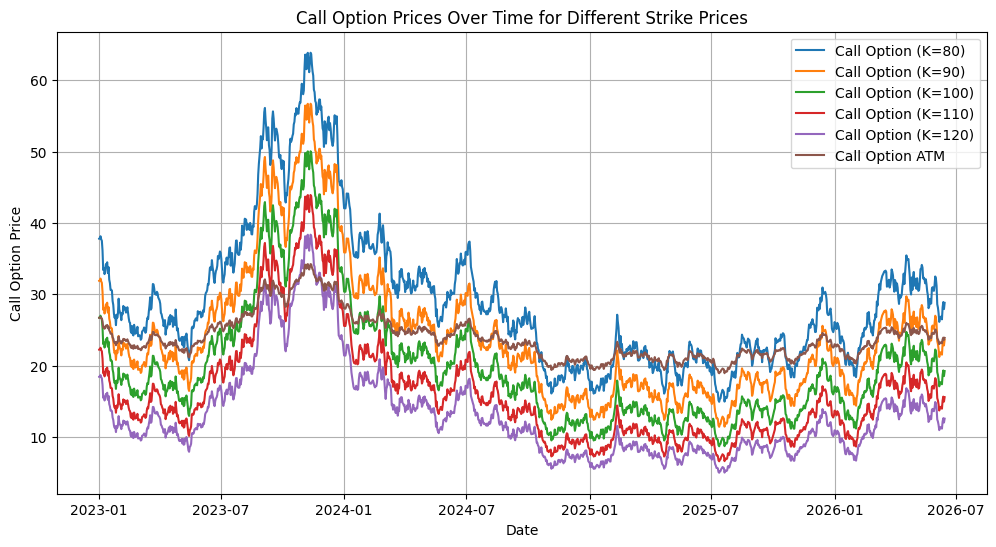

In [83]:
plt.figure(figsize=(12, 6))

for K in strike_prices:
    plt.plot(asset_prices_df['Time'], asset_prices_df[f'Call_{K}'], label=f'Call Option (K={K})')

plt.plot(asset_prices_df['Time'], asset_prices_df['Call_ATM'], label=f'Call Option ATM')

plt.xlabel('Date')
plt.ylabel('Call Option Price')
plt.title('Call Option Prices Over Time for Different Strike Prices')
plt.legend()
plt.grid(True)
plt.show()

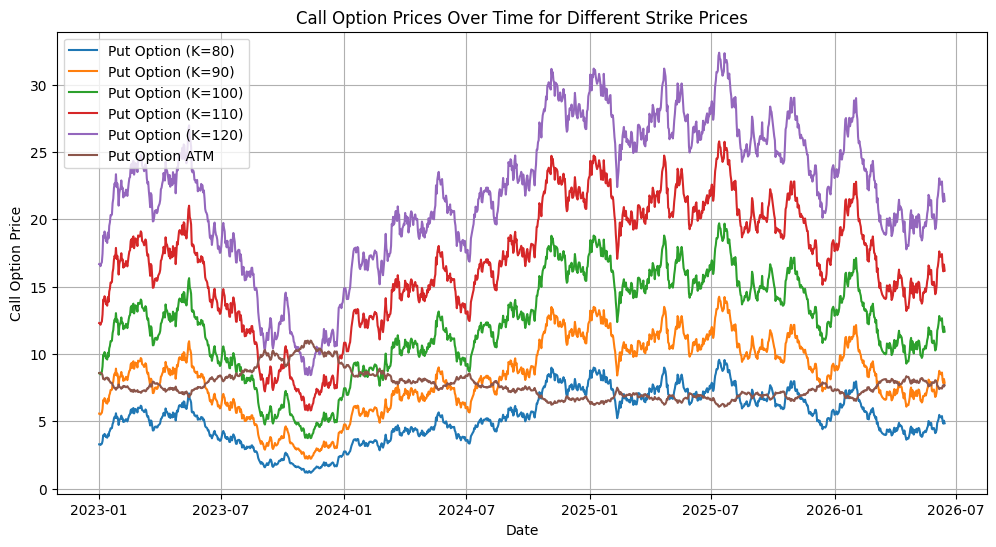

In [84]:
plt.figure(figsize=(12, 6))

for K in strike_prices:
    plt.plot(asset_prices_df['Time'], asset_prices_df[f'Put_{K}'], label=f'Put Option (K={K})')

plt.plot(asset_prices_df['Time'], asset_prices_df['Put_ATM'], label=f'Put Option ATM')

plt.xlabel('Date')
plt.ylabel('Call Option Price')
plt.title('Call Option Prices Over Time for Different Strike Prices')
plt.legend()
plt.grid(True)
plt.show()

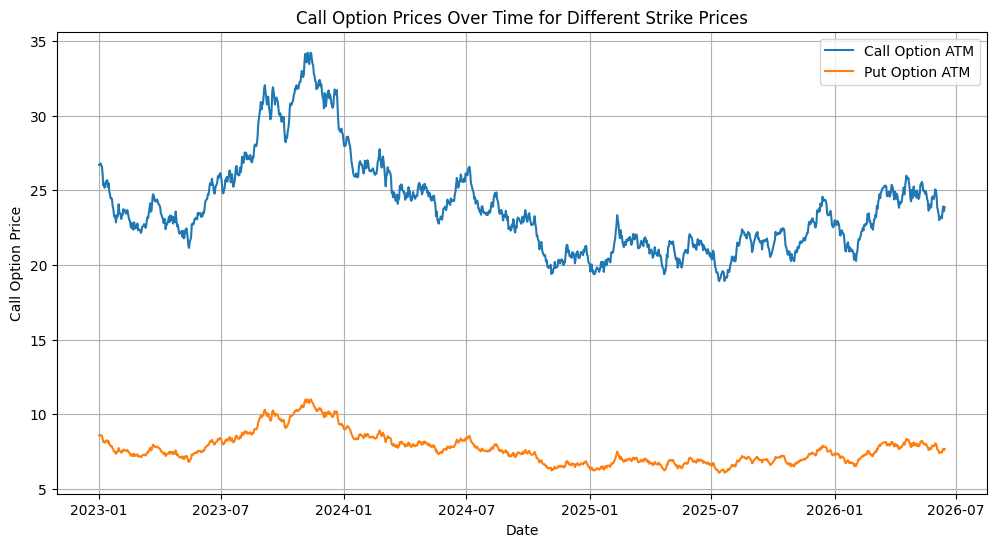

In [85]:
plt.figure(figsize=(12, 6))
plt.plot(asset_prices_df['Time'], asset_prices_df['Call_ATM'], label=f'Call Option ATM')
plt.plot(asset_prices_df['Time'], asset_prices_df['Put_ATM'], label=f'Put Option ATM')

plt.xlabel('Date')
plt.ylabel('Call Option Price')
plt.title('Call Option Prices Over Time for Different Strike Prices')
plt.legend()
plt.grid(True)
plt.show()

In [89]:
# Store the dataframe in the data folder as an excel file

# Save the dataframe as an Excel file
asset_prices_df.to_excel('data/datafile01.xlsx', index=False)